In [1]:
!pip install pennylane

  Using cached PennyLane-0.31.0-py3-none-any.whl (1.4 MB)
  Using cached PennyLane_Lightning-0.31.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached autograd-1.5-py3-none-any.whl (48 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached autoray-0.6.3-py3-none-any.whl (48 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)

[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from pennylane import numpy as np

symbols = ["A","P","R","L","R","F","R","Y","L","A"] # for H2 atom
coordinates = np.array([0.0,0.0,0.0, 0.5773502691896258, 0.5773502691896258, -0.5773502691896258, 
                       1.1547005383792517, 0.0, -1.1547005383792517, 1.7320508075688776, -0.5773502691896258, -0.5773502691896258,
                       1.154700538379252, -1.1547005383792517, 0.0, 1.7320508075688776, -1.7320508075688776, 0.5773502691896258,
                       1.154700538379252, -2.3094010767585034, 1.1547005383792517, 0.5773502691896261, -2.886751345948129, 0.5773502691896258,
                       1.7320508075688776, 0.5773502691896258, -0.5773502691896258,1.7320508075688776, -1.7320508075688776, -0.5773502691896258])

In [3]:
coordinates

tensor([ 0.        ,  0.        ,  0.        ,  0.57735027,  0.57735027,
        -0.57735027,  1.15470054,  0.        , -1.15470054,  1.73205081,
        -0.57735027, -0.57735027,  1.15470054, -1.15470054,  0.        ,
         1.73205081, -1.73205081,  0.57735027,  1.15470054, -2.30940108,
         1.15470054,  0.57735027, -2.88675135,  0.57735027,  1.73205081,
         0.57735027, -0.57735027,  1.73205081, -1.73205081, -0.57735027], requires_grad=True)

In [7]:
import pennylane as qml

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is", H)

Traceback (most recent call last):
  Cell In[7], line 3
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
  File /opt/conda/lib/python3.10/site-packages/pennylane/qchem/openfermion_obs.py:957 in molecular_hamiltonian
    mol = qml.qchem.Molecule(
  File /opt/conda/lib/python3.10/site-packages/pennylane/qchem/molecule.py:94 in __init__
    raise ValueError(f"Atoms in {set(symbols) - set(atomic_numbers)} are not supported.")
ValueError: Atoms in {'R', 'P', 'L', 'A', 'Y'} are not supported.

Use %tb to get the full traceback.


In [5]:
dev = qml.device("default.qubit", wires=qubits)

In [6]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits) # Hartree-Fock State
print(hf)

[1 1 0 0]


In [7]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0,1,2,3])

In [8]:
@qml.qnode(dev, interface='autograd')

def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [10]:
theta = np.array(0.0, requires_grad=True)

In [11]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


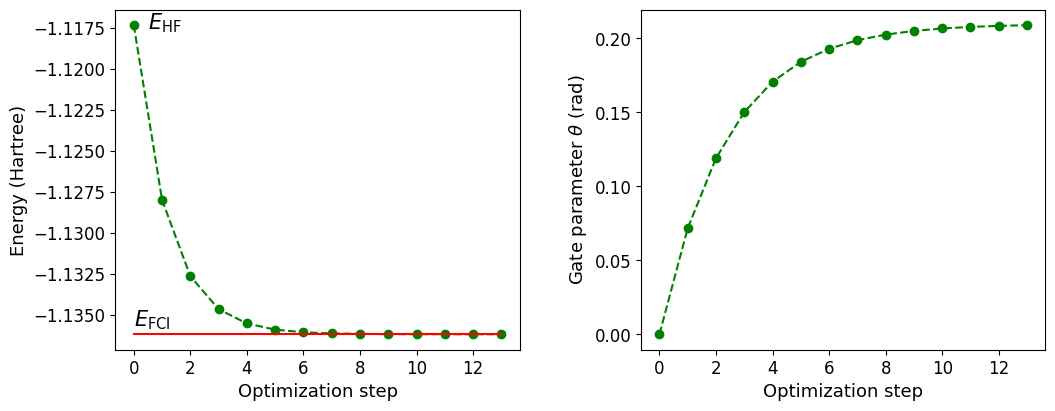

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()